In [5]:
####################################################
##                                                ##
##              Итоговая работа по ML             ##
##                                                ##
####################################################

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io

def explore(dataframe):
    
    print("Total Records: ", dataframe.shape[0])
          
    
    x = dataframe.columns[dataframe.isnull().any()].tolist()   
    if not x:
        print("No Missing/Null Records")
    else:        
        print("Found Missing Records")

#Смотрим путь хама и спама(Подойдут любые форматы данных)
def msgs(path):
  data = []
  #path = 'content/'
  files = [f for f in os.listdir(path)]
  for file in files:
    with io.open(path+file, "r", errors='ignore') as f:
      data.append(f.read())
      
  return data


In [6]:
df_train_ham = pd.DataFrame({'Message': msgs('C:/ItogovoeZadanie/content/enron/ham/'), 'Category': 0})
df_train_spam = pd.DataFrame({'Message': msgs('C:/ItogovoeZadanie/content/enron/spam/'), 'Category': 1})

df_test_ham = pd.DataFrame({'Message': msgs('C:/ItogovoeZadanie/content/teachertest/ham/'), 'Category': 0})
df_test_spam = pd.DataFrame({'Message': msgs('C:/ItogovoeZadanie/content/teachertest/spam/'), 'Category': 1})

df = pd.concat([df_train_ham, df_train_spam, df_test_ham, df_test_spam], ignore_index=True)
print("Total: ", df.shape)
df.head()


Total:  (35295, 2)


,Message,Category
0,Subject: christmas tree farm pictures\n,0
1,Subject: re : rankings\nthank you .,0
2,Subject: leadership development pilot\nsally :...,0
3,Subject: key dates and impact of upcoming sap ...,0
4,Subject: key hr issues going forward\na ) year...,0


In [7]:
#Разведка данных(можно что-то добавить)
print("Total Number of spam messages in data: ", df[df['Category']==1].shape[0])
print("Total Number of non-spam messages in data: ", df[df['Category']==0].shape[0])

Total Number of spam messages in data:  18150
Total Number of non-spam messages in data:  17145


In [8]:
word_counts = df['Message'].apply(lambda x: len(x.split()))
word_counts.describe()

count    35295.000000
mean       322.329848
std        844.094238
min          1.000000
25%         75.000000
50%        162.000000
75%        352.000000
max      45451.000000
Name: Message, dtype: float64

In [9]:
explore(df)

Total Records:  35295
No Missing/Null Records


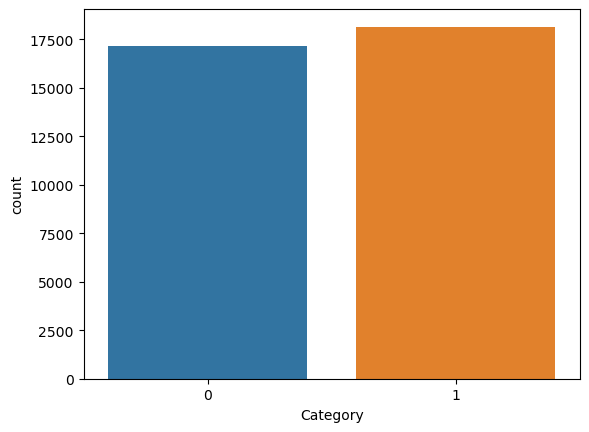

In [10]:
import seaborn as sns
sns.countplot(data=df, x="Category")
plt.show()

In [11]:
#Обработка
import re
import nltk
nltk.download()
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

my_stopwords = ["subject"]

stop_words = stopwords.words('english') 
stop_words.extend(my_stopwords)
stop_words.remove('not') 
lemmatizer = WordNetLemmatizer()

def data_preprocessing(Message):
    
  # Очиста от ненужного
  Message = re.sub(re.compile('<.*?>'), '', Message) 
  Message =  re.sub('[^A-Za-z0-9]+', ' ', Message) 
  Message = Message.lower()
  
  #Делаем токены
  tokens = nltk.word_tokenize(Message) 

  #Приводим к нормальной форме письма
  Message = [word for word in tokens if word not in stop_words]
  Message = [lemmatizer.lemmatize(word) for word in Message]
  Message = ' '.join(Message)
  
  return Message

df['Preprocessed_Message'] = df['Message'].apply(lambda Message: data_preprocessing(Message))
df.head()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Message,Category,Preprocessed_Message
0,Subject: christmas tree farm pictures\n,0,christmas tree farm picture
1,Subject: re : rankings\nthank you .,0,ranking thank
2,Subject: leadership development pilot\nsally :...,0,leadership development pilot sally timing ask ...
3,Subject: key dates and impact of upcoming sap ...,0,key date impact upcoming sap implementation ne...
4,Subject: key hr issues going forward\na ) year...,0,key hr issue going forward year end review rep...


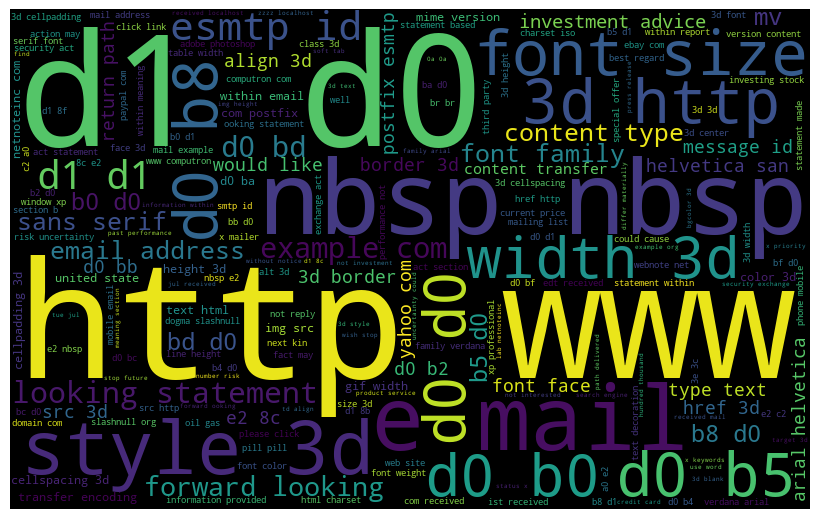

In [12]:
from wordcloud import WordCloud

#Не шаблонные слова
words_list = df[df['Category']==1]['Preprocessed_Message'].unique().tolist()
pos_words = " ".join(words_list)

pos_wordcloud =  WordCloud(
                  width=800, height = 500,            
                  stopwords=stop_words).generate(pos_words)

plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

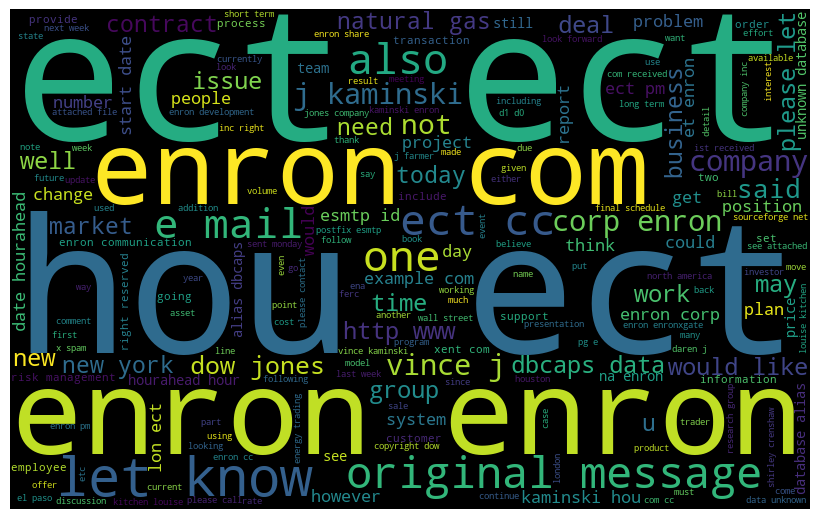

In [13]:
#Спам слова
words_list = df[df['Category']==0]['Preprocessed_Message'].unique().tolist()
neg_words = " ".join(words_list)

neg_wordcloud =  WordCloud(
                  width=800, height = 500,            
                  stopwords=stop_words).generate(neg_words)

plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(neg_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [14]:
#Сплит на тест и треин данные
from sklearn.model_selection import train_test_split

data = df.copy()
y = data['Category'].values
data.drop(['Category'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.55, stratify=y, random_state=30)

print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (15882, 2) (15882,)
Test data: (19413, 2) (19413,)


In [15]:
#Считаем BOW
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(min_df=10)

X_train_message_bow = vect.fit_transform(X_train['Preprocessed_Message'])
X_test_message_bow = vect.transform(X_test['Preprocessed_Message'])

print('X_train_message_bow shape: ', X_train_message_bow.shape)
print('X_test_message_bow shape: ', X_test_message_bow.shape)

X_train_message_bow shape:  (15882, 13822)
X_test_message_bow shape:  (19413, 13822)


In [16]:
#Считаем TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10)

X_train_message_tfidf = vectorizer.fit_transform(X_train['Preprocessed_Message'])
X_test_message_tfidf = vectorizer.transform(X_test['Preprocessed_Message'])

print('X_train_message_tfidf shape: ', X_train_message_tfidf.shape)
print('X_test_message_tfidf shape: ', X_test_message_tfidf.shape)

X_train_message_tfidf shape:  (15882, 13822)
X_test_message_tfidf shape:  (19413, 13822)


In [17]:
#теорема Байса(Наивный Байс) через BOW
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

clf = MultinomialNB()
clf.fit(X_train_message_bow, y_train)

y_pred = clf.predict(X_test_message_bow) #prediction from model

NB_BOW_AS = accuracy_score(y_test, y_pred)
NB_BOW_PS = precision_score(y_test, y_pred)
NB_BOW_RS = recall_score(y_test, y_pred)
print('Test Accuracy: ', NB_BOW_AS)
print('Test Precision: ', NB_BOW_PS)
print('Test Recall: ', NB_BOW_RS) 

Test Accuracy:  0.9789831556173698
Test Precision:  0.9773656396450294
Test Recall:  0.9818691776019233


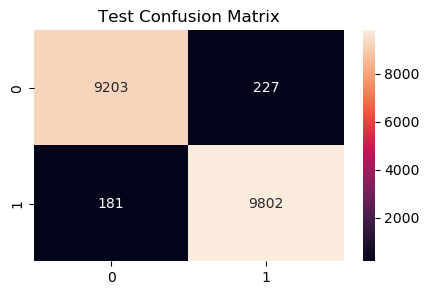

In [18]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

In [19]:
#теорема Байса(Наивный Байс) через TFIDF
clf = MultinomialNB(alpha=1)
clf.fit(X_train_message_tfidf, y_train)

y_pred = clf.predict(X_test_message_tfidf)
NB_TFIDF_AS = accuracy_score(y_test, y_pred)
NB_TFIDF_PS = precision_score(y_test, y_pred)
NB_TFIDF_RS = recall_score(y_test, y_pred)
print('Test Accuracy: ', NB_TFIDF_AS)
print('Test Precision: ', NB_TFIDF_PS)
print('Test Recall: ', NB_TFIDF_RS)

Test Accuracy:  0.9828465461288827
Test Precision:  0.9788606589916634
Test Recall:  0.9879795652609437


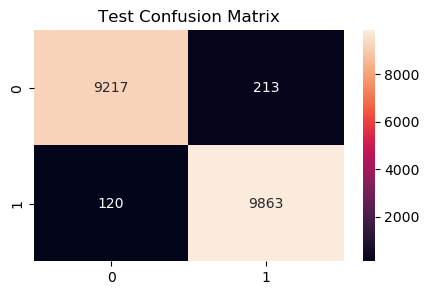

In [20]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

In [21]:
#Лог регрессия через TFIDF
import warnings
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')

clf = LogisticRegression(penalty='l2')
clf.fit(X_train_message_tfidf, y_train)

y_pred = clf.predict(X_test_message_tfidf)

LR_TFIDF_AS = accuracy_score(y_test, y_pred)
LR_TFIDF_PS = precision_score(y_test, y_pred)
LR_TFIDF_RS = recall_score(y_test, y_pred)
print('Test Accuracy: ', LR_TFIDF_AS)
print('Test Precision: ', LR_TFIDF_PS)
print('Test Recall: ', LR_TFIDF_RS)

Test Accuracy:  0.9835677123576985
Test Precision:  0.9749361116571653
Test Recall:  0.9935891014725032


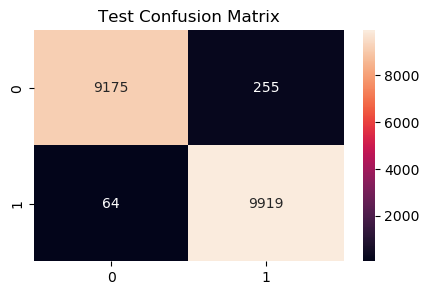

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

In [23]:
#Все результаты исследования
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ['Vectorizer', 'Model', 'Accuracy', 'Precision', 'Recall']
x.add_row(['BOW', 'Naive Bayes', NB_BOW_AS, NB_BOW_PS, NB_BOW_RS])
x.add_row(['TFIDF', 'Naive Bayes', NB_TFIDF_AS, NB_TFIDF_PS, NB_TFIDF_RS])
x.add_row(['TFIDF', 'Logistic Regression', LR_TFIDF_AS, LR_TFIDF_PS, LR_TFIDF_RS])
print(x)

+------------+---------------------+--------------------+--------------------+--------------------+
| Vectorizer |        Model        |      Accuracy      |     Precision      |       Recall       |
+------------+---------------------+--------------------+--------------------+--------------------+
|    BOW     |     Naive Bayes     | 0.9789831556173698 | 0.9773656396450294 | 0.9818691776019233 |
|   TFIDF    |     Naive Bayes     | 0.9828465461288827 | 0.9788606589916634 | 0.9879795652609437 |
|   TFIDF    | Logistic Regression | 0.9835677123576985 | 0.9749361116571653 | 0.9935891014725032 |
+------------+---------------------+--------------------+--------------------+--------------------+
